## Time-Series Analysis (10 Minute Sliding Window)

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")
df.drop(columns=['HRV_SDANN'], inplace=True)

# Define constants
window_size = 10
feature_cols = [
    'SCL_Mean', 'SCL_STD', 'SCR_Peaks_Count', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_pNN50',
    'HRV_MeanRR', 'HRV_MedianRR', 'HRV_HF', 'HRV_LF', 'HRV_LF_HF_Ratio',
    'HRV_SampEN'
]

# Build dataset
X_all, y_all, group_ids = [], [], []

for patient_id, group in df.groupby('Patient_ID'):
    group = group.dropna(subset=['PANAS_PA']).reset_index(drop=True)
    group = group.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_cols)
    if len(group) <= window_size:
        continue

    scaler = MinMaxScaler()
    try:
        group[feature_cols] = scaler.fit_transform(group[feature_cols])
    except ValueError:
        continue

    for i in range(window_size, len(group)):
        window_feat = group.iloc[i - window_size:i][feature_cols].values[:-1].flatten()
        past_labels = group.iloc[i - window_size:i]['PANAS_PA'].values[:-1]
        full_features = np.concatenate([window_feat, past_labels])
        target = group.iloc[i]['PANAS_PA']

        X_all.append(full_features)
        y_all.append(target)
        group_ids.append(patient_id)

X_all = np.array(X_all)
y_all = np.array(y_all)
group_ids = np.array(group_ids)

# Define models and hyperparameter grids
models = {
     "LinearRegression": (LinearRegression(), {}),
    "RandomForest": (RandomForestRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3]
    }),
    "DecisionTree": (DecisionTreeRegressor(), {
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3]
    }),
    "XGBoost": (XGBRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1],
        "reg_lambda": [1, 5],
        "subsample": [0.7, 1.0]
    }),
    "LightGBM": (LGBMRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.01, 0.1],
        "reg_lambda": [0.0, 1.0]
    }),
    "AdaBoost": (AdaBoostRegressor(), {
        "n_estimators": [50, 100],
        "learning_rate": [0.1, 0.5, 1.0]
    }),
    "SVM": (SVR(), {
        "kernel": ["linear", "rbf"],
        "C": [0.1, 1.0, 10.0],
        "epsilon": [0.1, 0.5, 1.0]
    }),
}

# List of models that require feature scaling
scale_sensitive_models = ["SVM", "LinearRegression"]

# Prepare GroupKFold
gkf = GroupKFold(n_splits=5)

# Store best models and evaluation metrics
evaluation_results = []

# Perform hyperparameter tuning and evaluation
for model_name, (model, param_grid) in models.items():
    best_model = None
    best_score = 0
    all_preds = []
    all_true = []

    for train_idx, test_idx in gkf.split(X_all, y_all, groups=group_ids):
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        # Apply MinMaxScaler only if model is scale-sensitive
        if model_name in scale_sensitive_models:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    # Final evaluation
    mse = mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)
    r2 = r2_score(all_true, all_preds)

    evaluation_results.append({
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Best Params': grid.best_params_,
    })

# Display results in a DataFrame (excluding confusion matrix)
results_df = pd.DataFrame([{k: v for k, v in r.items()} for r in evaluation_results])

results_df


Output hidden; open in https://colab.research.google.com to view.

In [3]:
pd.set_option('display.max_colwidth', None)

results_df

,Model,MSE,MAE,R2,Best Params
0,LinearRegression,16.294411,2.830287,0.679136,{}
1,RandomForest,17.163947,2.533565,0.662013,"{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}"
2,DecisionTree,20.975500,3.027668,0.586958,"{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}"
3,XGBoost,17.486480,2.970613,0.655662,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 5, 'subsample': 0.7}"
4,LightGBM,18.182159,2.885554,0.641963,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 0.0}"
5,AdaBoost,21.380743,3.334611,0.578978,"{'learning_rate': 0.1, 'n_estimators': 50}"
6,SVM,15.465136,1.814614,0.695466,"{'C': 10.0, 'epsilon': 0.5, 'kernel': 'linear'}"


In [4]:
results_df.to_csv("/content/drive/MyDrive/Capstone/results/time-series_PA_best_models.csv")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18123
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 108
[LightGBM] [Info] Start training from score 23.859206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

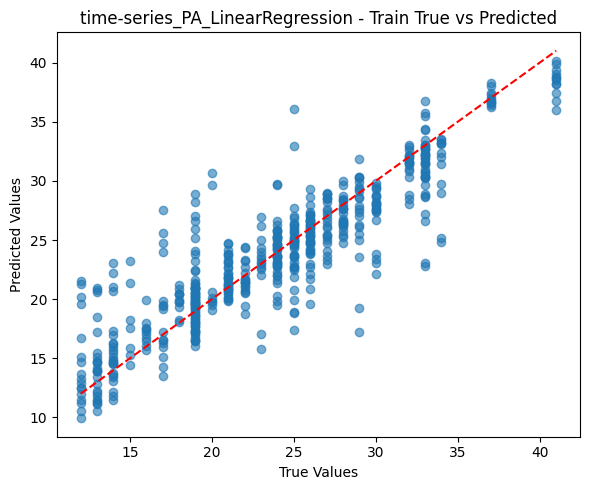

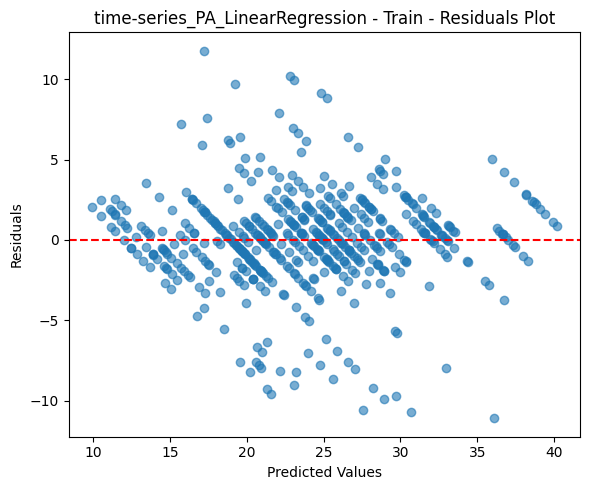

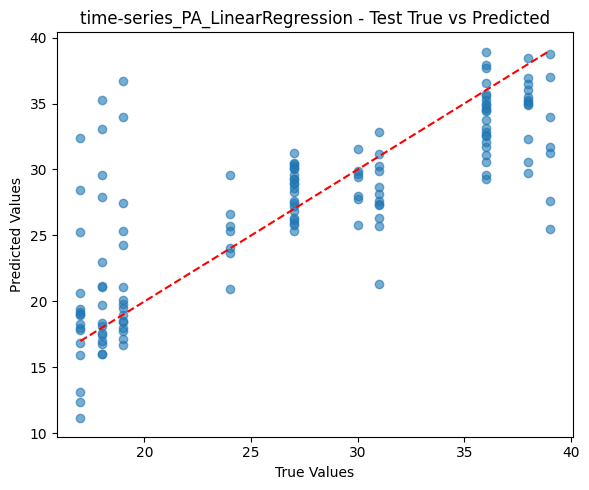

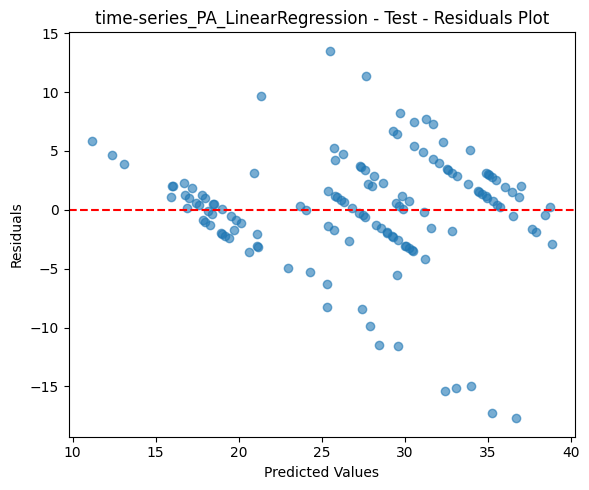

Evaluating RandomForest...


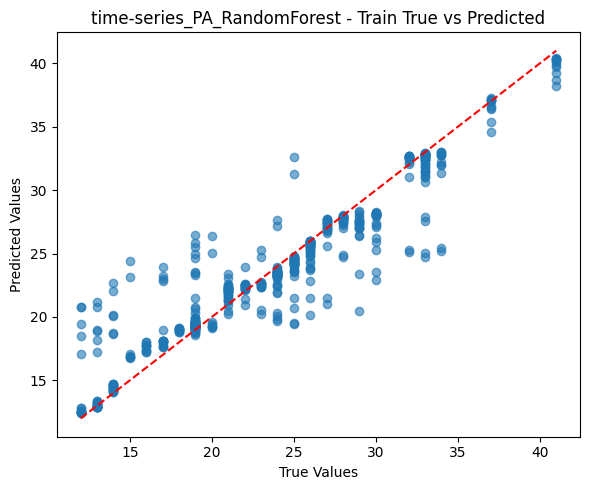

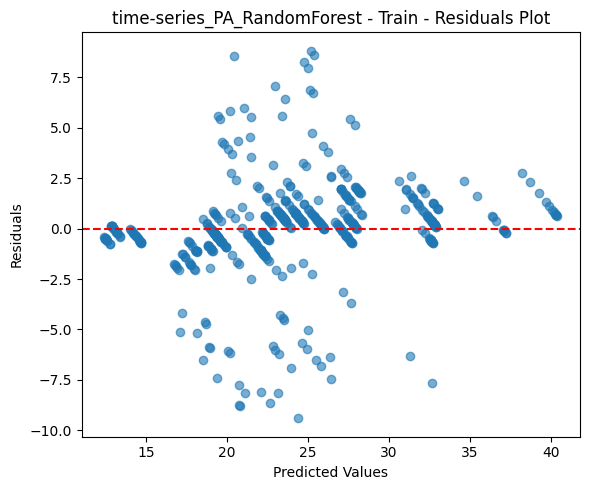

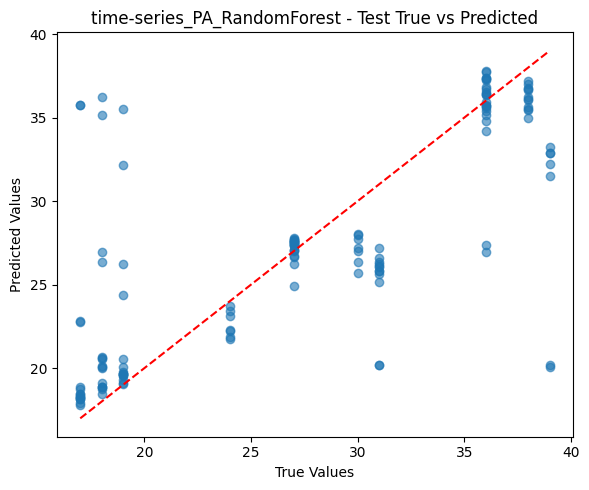

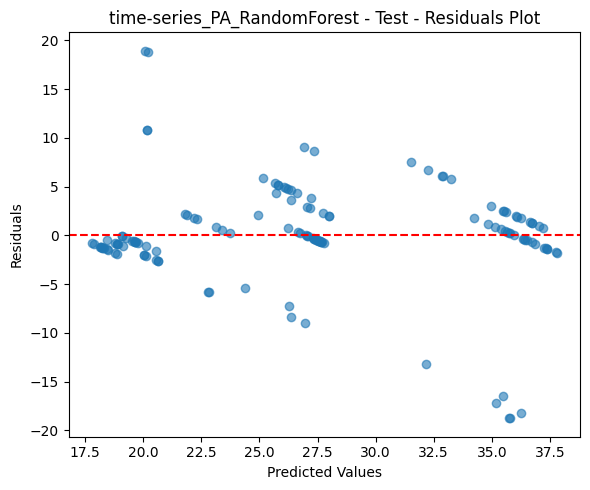

Evaluating DecisionTree...


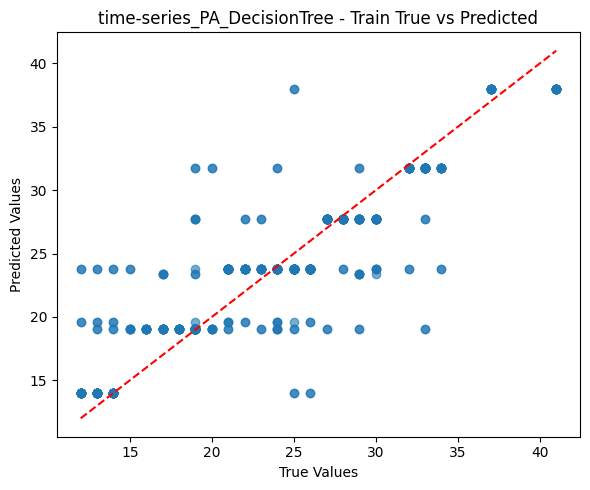

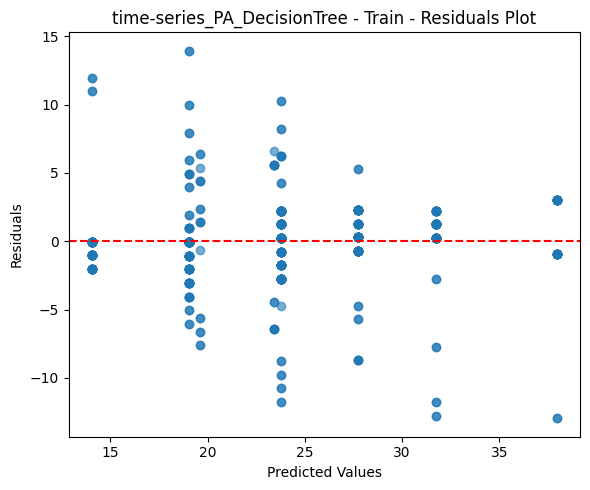

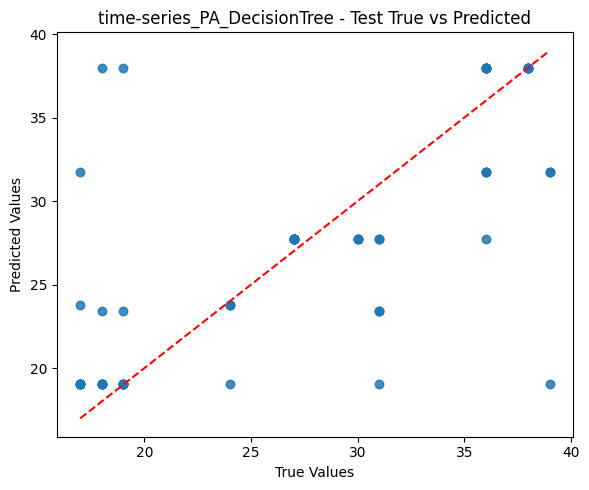

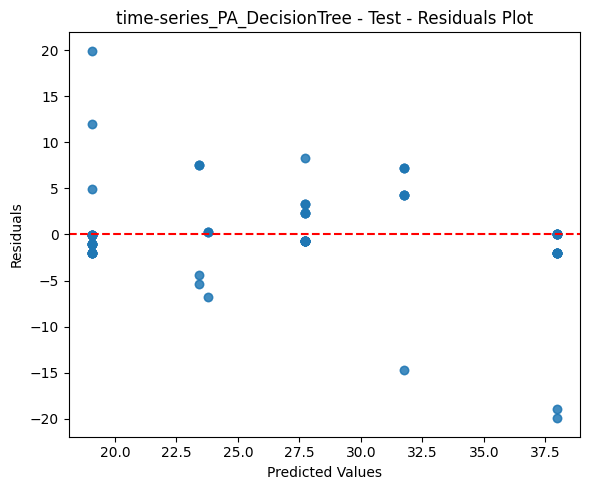

Evaluating XGBoost...


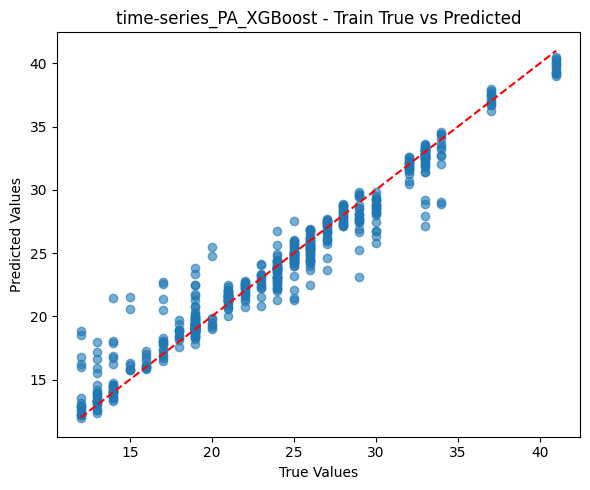

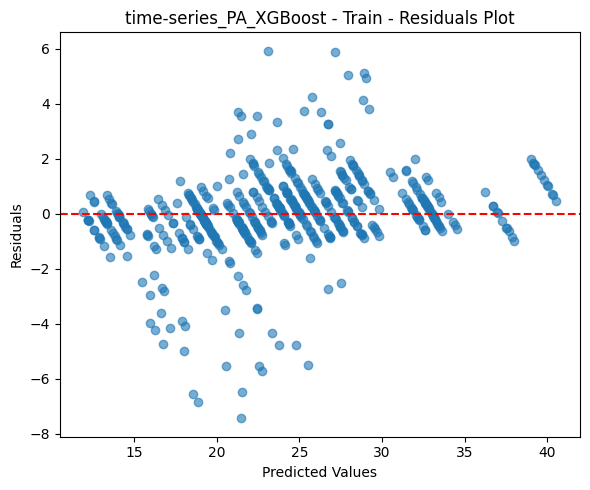

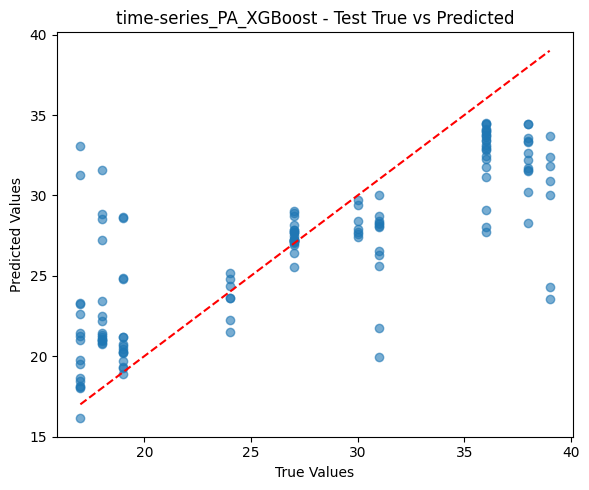

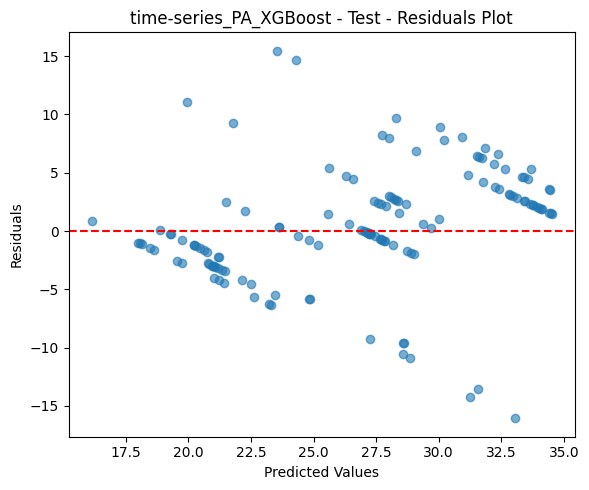

Evaluating LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


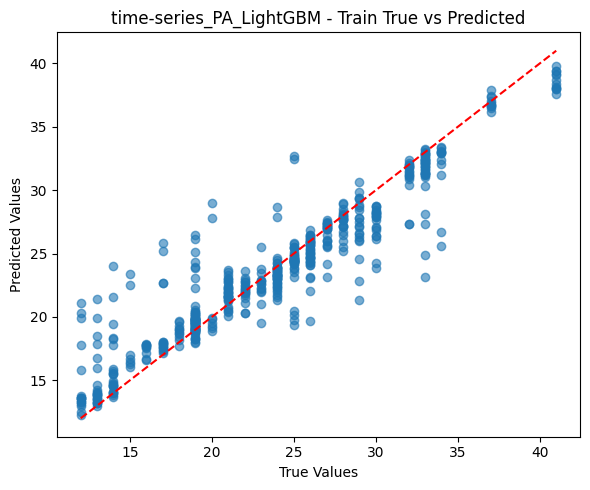

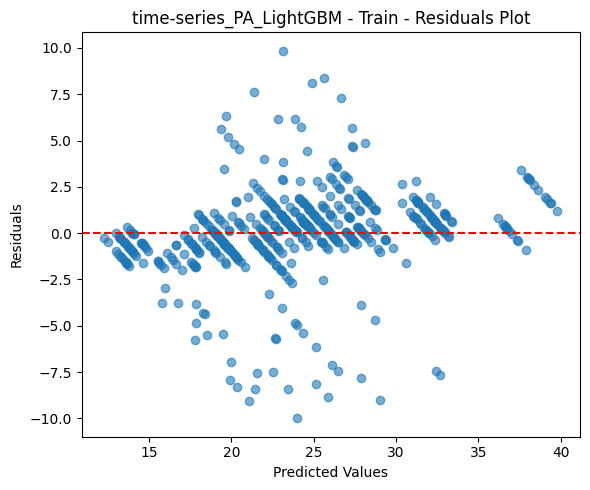

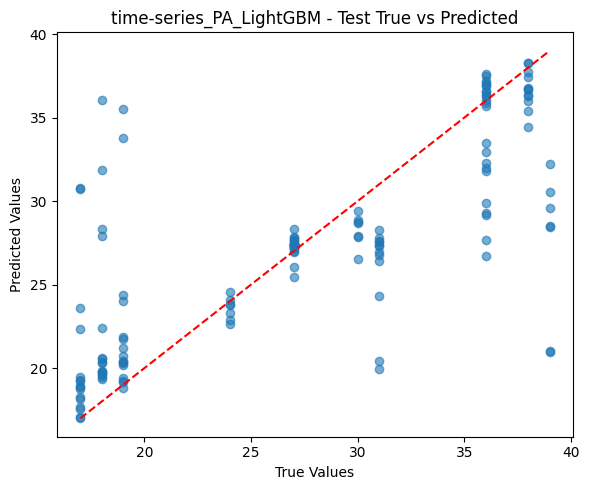

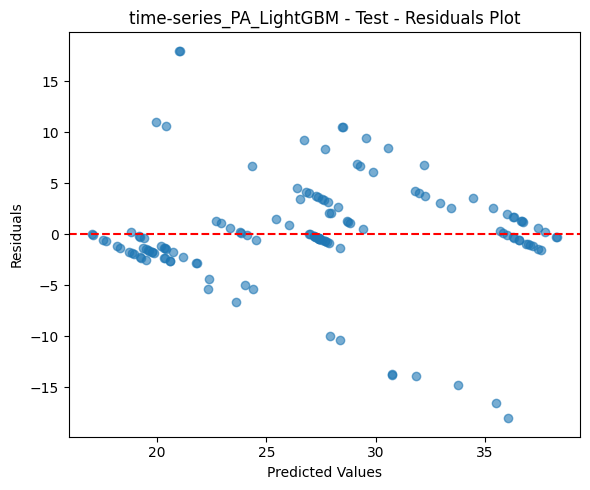

Evaluating AdaBoost...


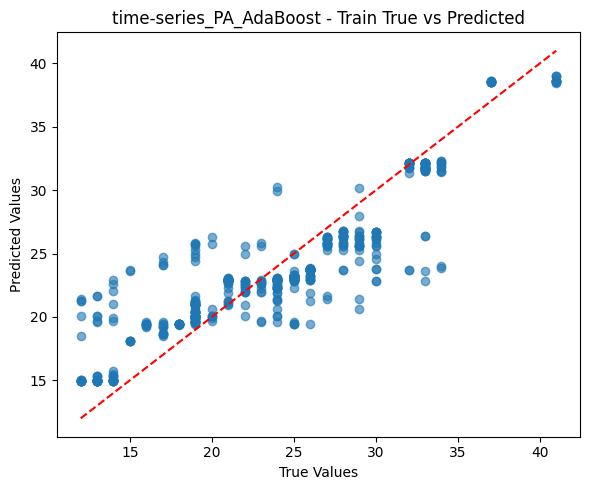

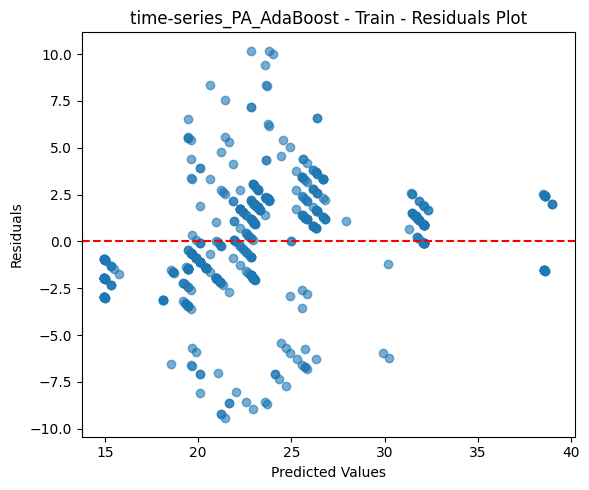

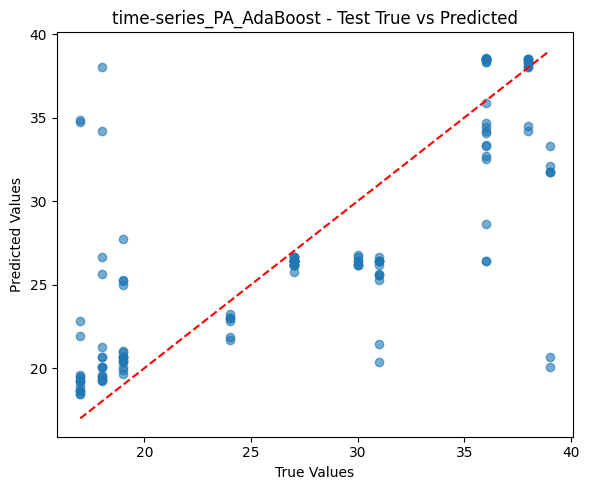

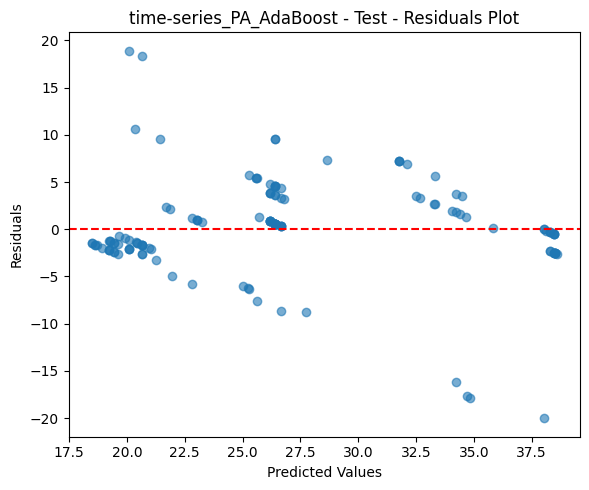

Evaluating SVM...


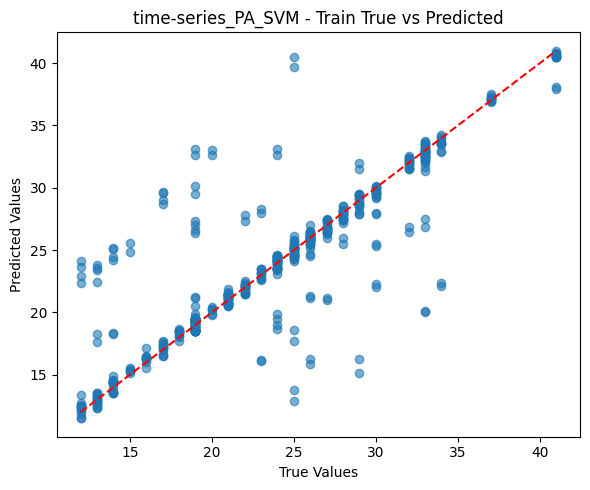

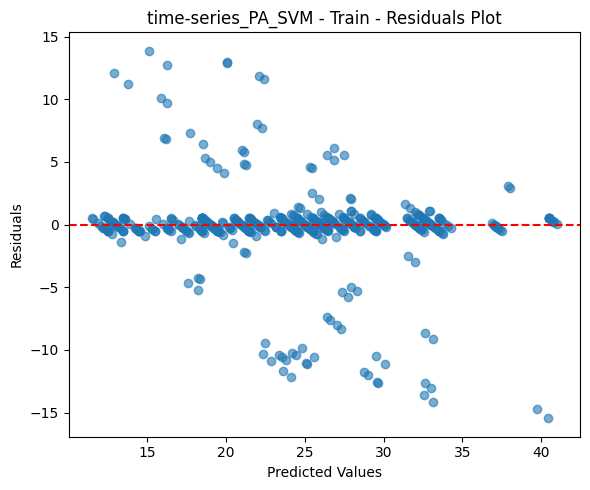

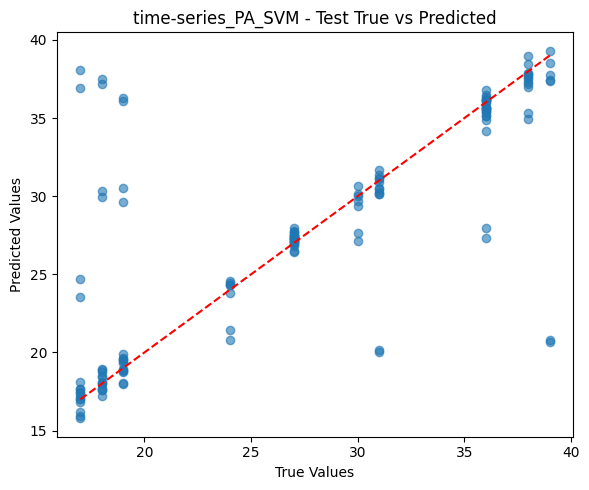

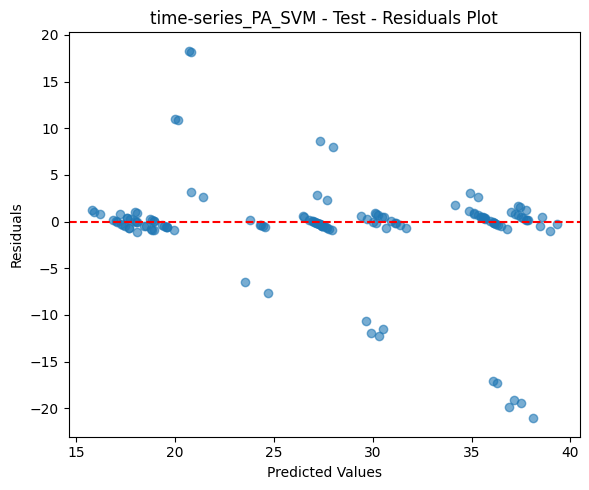

              Model  Train MSE   Test MSE  Train MAE  Test MAE  Train R2  \
0  LinearRegression   8.818240  24.276681   2.032696  3.344374  0.806882   
1      RandomForest   5.454073  27.887341   1.398162  3.082635  0.880557   
2      DecisionTree  11.810911  31.184350   2.198396  3.260535  0.741343   
3           XGBoost   2.308889  24.937769   0.954541  3.638140  0.949436   
4          LightGBM   5.483555  27.180379   1.468697  3.207519  0.879911   
5          AdaBoost   9.121725  26.718180   2.319386  3.362029  0.800236   
6               SVM  11.711884  28.652780   1.491653  2.336235  0.743512   

    Test R2  
0  0.608165  
1  0.549887  
2  0.496672  
3  0.597495  
4  0.561298  
5  0.568758  
6  0.537533  


In [5]:
from evaluation import full_regression_evaluation

# Define your best models
best_models = {
    "LinearRegression": LinearRegression().fit(X_train, y_train),
    "RandomForest": RandomForestRegressor(max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100).fit(X_train, y_train),
    "DecisionTree": DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=2).fit(X_train, y_train),
    "XGBoost": XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=5, subsample=0.7).fit(X_train, y_train),
    "LightGBM": LGBMRegressor(learning_rate=0.1, max_depth=3, n_estimators=50, reg_lambda=0.0).fit(X_train, y_train),
    "AdaBoost": AdaBoostRegressor(learning_rate=0.1, n_estimators=50).fit(X_train, y_train),
    "SVM": SVR(C=10.0, epsilon=0.5, kernel='linear').fit(X_train, y_train)
    }

# Store evaluation results
evaluation_summaries = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    results = full_regression_evaluation(model, X_train, y_train, X_test, y_test, model_name, data_type="time-series_PA")

    evaluation_summaries.append({
        'Model': model_name,
        'Train MSE': results['Train']['MSE'],
        'Test MSE': results['Test']['MSE'],
        'Train MAE': results['Train']['MAE'],
        'Test MAE': results['Test']['MAE'],
        'Train R2': results['Train']['R2'],
        'Test R2': results['Test']['R2']
    })

# Convert to DataFrame for comparison
eval_df = pd.DataFrame(evaluation_summaries)
print(eval_df)


In [6]:
eval_df.to_csv("/content/drive/MyDrive/Capstone/results/time-series_PA_best_models_eval.csv")

In [7]:
# Generate time-aware feature names
time_steps = 10
label_feature_names = [f'past_PA_t-{i}' for i in reversed(range(1, time_steps + 1))]

# Create time-aware feature names
time_series_features = []
for i in reversed(range(1, time_steps + 1)):
    time_series_features.extend([f'{f}_t-{i}' for f in feature_cols])

# Final feature name list
full_feature_names = time_series_features + label_feature_names


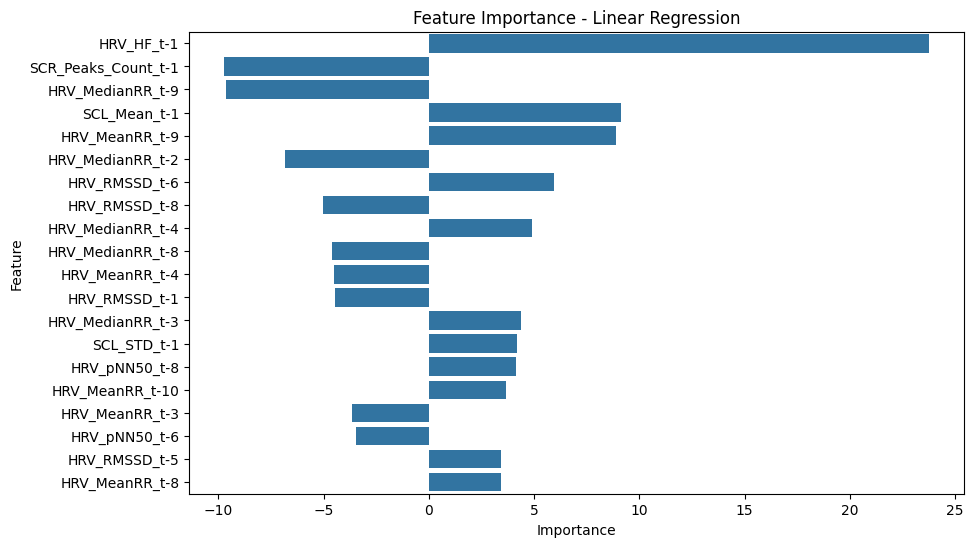

In [8]:
from feature_importance import plot_feature_importance
def plot_feature_importance2(model, feature_names, model_name, coef_type="coef", top_n=20, save_path=None):
    """Plots feature importance for a given model.

    Args:
        model: The trained model.
        feature_names: List of feature names.
        model_name: Name of the model (for plot title).
        coef_type: Type of coefficient to use ('coef' or 'feature_importances_').
        top_n: Number of top features to display.
        save_path: Path to save the plot (optional).
    """
    try:
        if coef_type == "coef":
            importances = model.coef_
        else:
            importances = model.feature_importances_
    except AttributeError:
        # Handle cases where the model doesn't have the specified attribute (e.g., coef_ or feature_importances_)
        print(f"Error: Model '{model_name}' does not have attribute '{coef_type}'. Skipping feature importance plot.")
        return  # Exit the function early to prevent further errors

    # Check if 'importances' is a scalar and convert it to a list if necessary
    if np.isscalar(importances):
        importances = [importances]  # Convert scalar to a list with one element

    # Ensure feature_names and importances have the same length
    feature_names = feature_names[:len(importances)]

    # Create dataframe
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Sort by absolute importance
    feature_importance_df['abs_importance'] = feature_importance_df['importance'].abs()
    feature_importance_df = feature_importance_df.sort_values(by=['abs_importance'], ascending=False)

    # Select top N features
    feature_importance_df = feature_importance_df.head(top_n)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
# Define your best models
best_lr_model = best_models['LinearRegression']
# Example usage with your trained models
plot_feature_importance2(best_lr_model, full_feature_names, model_name="Linear Regression", coef_type="coef", save_path="/content/drive/MyDrive/Capstone/figures/time-series_PA_lr_importances.png")


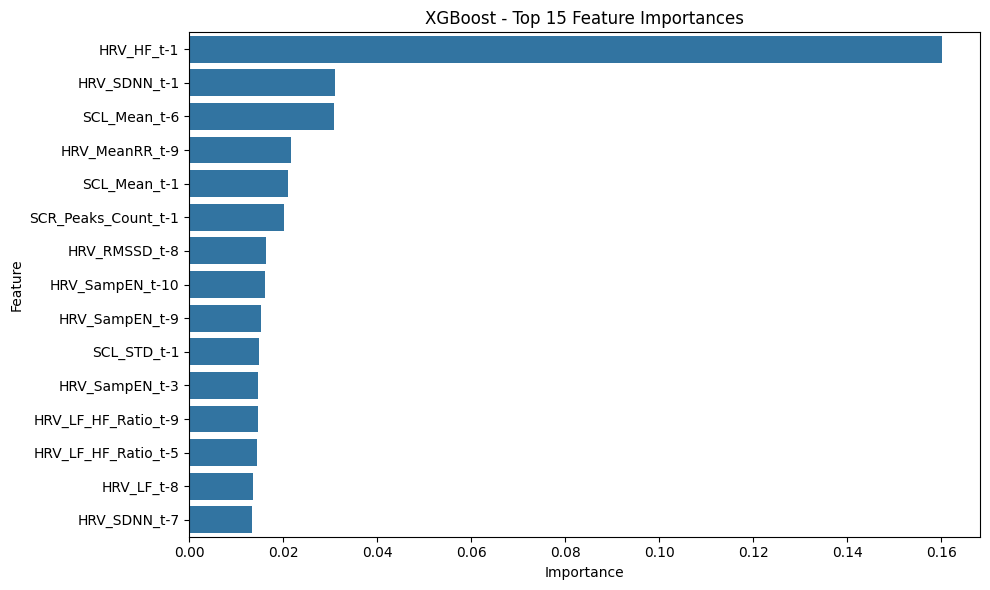

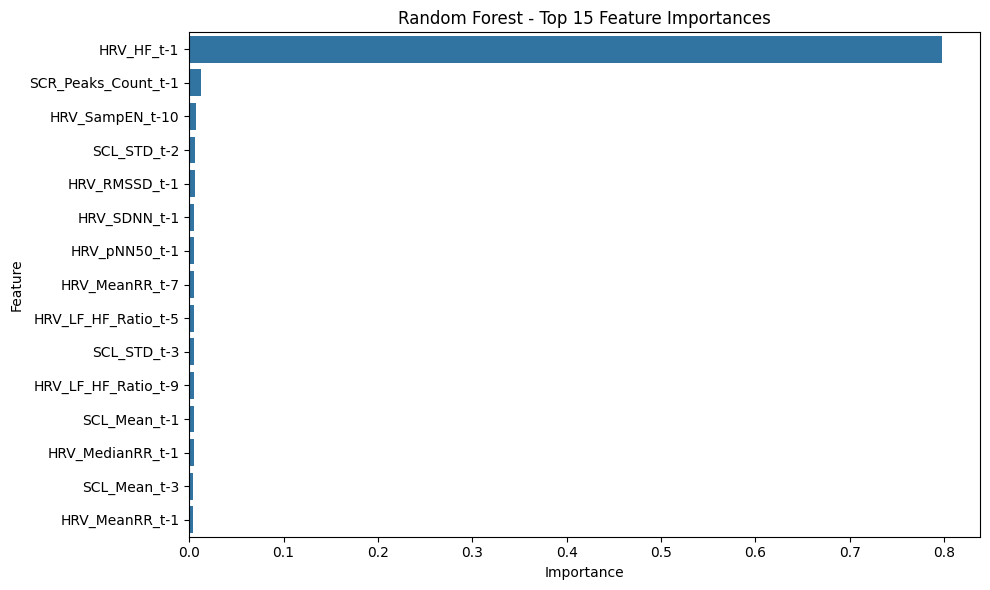

In [9]:
from feature_importance import plot_feature_importance

# Define your best models
best_lr_model = best_models['LinearRegression']
best_xgb_model = best_models['XGBoost']
best_rf_model = best_models['RandomForest']
# Example usage with your trained models
#plot_feature_importance(best_lr_model, full_feature_names, model_name="Linear Regression", coef_type="coef", save_path="/content/drive/MyDrive/Capstone/figures/time-series_lr_importances.png")
plot_feature_importance(best_xgb_model, full_feature_names, model_name="XGBoost", save_path="/content/drive/MyDrive/Capstone/figures/time-series_xgb_importances.png")
plot_feature_importance(best_rf_model, full_feature_names, model_name="Random Forest", save_path = "/content/drive/MyDrive/Capstone/figures/time-series_rf_importances.png")